In [1]:
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler

# Predicting US 2020 Presidential Election Winner by US County Based on Different Socio-Economic Factors

### A Classification Project by Nikolay Nikolov

## Introduction

In the present project, I conduct some exploratory data analysis on the results of the 2020 US presidential election by county, as well as train a classification algorithm that predicts which candidate each county has chosen based on different socio-economic factors.

The dataset I am using was customly created by me by taking the results of the election for each county and augmenting the dataset with data that, in my opinion, explains why a place would prefer to vote for one candidate over another.

Here are the different factors I take into account for each state:
* County population
* County area (in sq mi)
* Population density of the county
* Percentage of the population with a bachelors degree or higher
* County income per capita (in USD)
* Percentage of white people in the county
* Percentage of people living in poverty in the county
* Percentage of females in the population
* Percentage of people over 65 in the population

## I. Exploratory Data Analysis

Let's start by loading the data:

In [4]:
dataset = pd.read_csv('presidential_county_candidate.csv')
dataset

,county,population,area,population_density,bachelor_or_higher,income_per_cap,percent_white,percent_poverty,percent_females,percent_over_65,winner
0,"Autauga County, Alabama",55869,594,93.99,20.9,24571,76.7,12.1,51.4,15.6,Donald Trump
1,"Baldwin County, Alabama",223234,1590,140.42,27.7,26766,87.3,13.9,51.5,20.4,Donald Trump
2,"Barbour County, Alabama",24686,885,27.90,13.4,16829,49.1,26.7,47.2,19.4,Donald Trump
3,"Bibb County, Alabama",22394,623,35.97,12.1,17427,76.8,18.1,46.8,16.5,Donald Trump
4,"Blount County, Alabama",57826,645,89.68,12.1,20730,95.9,15.8,50.7,18.2,Donald Trump
...,...,...,...,...,...,...,...,...,...,...,...
3066,"Sweetwater County, Wyoming",42343,10426,4.06,18.1,30517,79.6,11.3,48.5,12.1,Donald Trump
3067,"Teton County, Wyoming",23464,4008,5.85,48.7,43444,80.7,8.2,48.4,15.4,Joe Biden
3068,"Uinta County, Wyoming",20226,2082,9.71,18.9,25513,87.5,13.3,49.3,14.1,Donald Trump
3069,"Washakie County, Wyoming",7805,2240,3.48,23.6,28308,82.6,12.1,49.4,21.7,Donald Trump


Let's now see what type of data we are dealing with and if there are any null values that we should take care of:

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3071 entries, 0 to 3070
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   county              3071 non-null   object 
 1   population          3071 non-null   int64  
 2   area                3071 non-null   int64  
 3   population_density  3071 non-null   float64
 4   bachelor_or_higher  3071 non-null   float64
 5   income_per_cap      3071 non-null   int64  
 6   percent_white       3071 non-null   float64
 7   percent_poverty     3071 non-null   float64
 8   percent_females     3071 non-null   float64
 9   percent_over_65     3071 non-null   float64
 10  winner              3071 non-null   object 
dtypes: float64(6), int64(3), object(2)
memory usage: 264.0+ KB


It seems like everything is fine there. Let's see some statistical info about the data:

In [6]:
dataset.describe()

,population,area,population_density,bachelor_or_higher,income_per_cap,percent_white,percent_poverty,percent_females,percent_over_65
count,3.071000e+03,3071.000000,3071.000000,3071.000000,3071.000000,3071.000000,3071.000000,3071.000000,3071.000000
mean,1.042112e+05,987.665581,214.827115,19.679779,23510.983393,83.369293,16.605015,49.891827,19.365321
std,3.349967e+05,1318.054493,1285.109479,8.709882,5492.037179,16.720588,6.492258,2.218689,4.644062
min,1.690000e+02,24.000000,0.240000,3.200000,7772.000000,5.400000,0.900000,26.800000,4.800000
25%,1.104250e+04,440.500000,16.620000,13.700000,19858.500000,77.500000,12.000000,49.400000,16.400000
50%,2.610800e+04,633.000000,43.400000,17.500000,22856.000000,90.400000,15.800000,50.300000,19.000000
75%,6.804750e+04,940.000000,109.435000,23.200000,26136.000000,95.000000,20.200000,51.000000,21.900000
max,1.003911e+07,20062.000000,48229.380000,71.700000,62498.000000,98.900000,54.000000,56.900000,57.600000


Since these are the mean values for all counties, those are also the mean values for the population of the United States as a whole. We can see the mean area and population density for a US county. Approximately 20% of the US population has earned a bachelor's degree. The mean income per capita for the country is $23,510. The percentage of white people in the country is 83\%. 16\% of the country's population lives in poverty. There are slightly less females than males in the population. Approximately 20\% of the population is over 65.

Let's now see how many counties both candidates have won:

In [7]:
print('No. counties won by Donald Trump:', len(dataset.loc[dataset['winner'] == 'Donald Trump']))
print('No. counties won by Joe Biden:', len(dataset.loc[dataset['winner'] == 'Joe Biden']))

No. counties won by Donald Trump: 2575
No. counties won by Joe Biden: 496


Very interesting. Joe Biden clearly won the popular vote by almost 6 million votes, and yet Donald Trump has won more than 5 times more counties than him. There is a clear explanation: there is a clear urban-rural division. Donald Trump may have won more counties, but the counties Joe Biden won have bigger cities and higher population overall.

Let's now glance into the mean values of the factors for counties won by Trump and for counties won by Biden:

In [8]:
criteria = ['population', 'area', 'population_density', 'bachelor_or_higher', 'income_per_cap', 'percent_white', "percent_poverty", "percent_females", "percent_over_65"]

for criterion in criteria:
    print('Mean Trump', criterion, round(dataset.loc[dataset['winner'] == 'Donald Trump'][criterion].mean(), 1))
print("\n")
for criterion in criteria:  
    print('Mean Biden', criterion, round(dataset.loc[dataset['winner'] == 'Joe Biden'][criterion].mean(), 1))

Mean Trump population 52103.6
Mean Trump area 955.1
Mean Trump population_density 87.0
Mean Trump bachelor_or_higher 18.0
Mean Trump income_per_cap 22981.3
Mean Trump percent_white 86.5
Mean Trump percent_poverty 16.3
Mean Trump percent_females 49.8
Mean Trump percent_over_65 19.8


Mean Biden population 374729.5
Mean Biden area 1156.9
Mean Biden population_density 878.6
Mean Biden bachelor_or_higher 28.1
Mean Biden income_per_cap 26260.7
Mean Biden percent_white 67.4
Mean Biden percent_poverty 18.3
Mean Biden percent_females 50.5
Mean Biden percent_over_65 17.1


We can draw quite a lot of conclusions solely based on these observations:
* The urban-rural division is clear from the mean population vales of both candidates. Donald Trump may have won 5 times more counties, but the mean population in the counties that Joe Biden won is more than 7 times that of Trump's counties. This is also evident by the huge difference in population density for the counties of both candidates.
* The area of counties won by Joe Biden is also slightly larger on average.
* Counties who chose Joe Biden have on average 10% more population with a bachelor's degree than counties who chose Donald Trump. This is quite a noticeable difference. Also, counties in which Donald Trump won have a mean population with a bachelor's degree just slightly less than the national average, whereas Joe Biden's counties have significantly more higher-educated people than the national average.
* The same thing can be said about the income per capita of the counties of both candidates.
* A noticeable difference is the percentage of white people in the counties who have voted for Donald Trump, which is a significant 19.1% larger than the percentage of those who chose Joe Biden.
* Interestingly enough, even though the income per capita of Joe Biden's counties is higher, the percentage of people living in poverty is also higher in his counties.
* As expected, there is almost the same percentage of males and females in Trump and Biden's counties, yet the percentage of females in Biden's counties is slightly larger.
* Finally, the percentage of people over 65 is slightly larger in Trump counties.

We can draw a general conclusion, that: counties who chose Joe Biden have a much larger urban population, contain more educated people and more well-off people on average and contain less white people and less elderly people. The slightly higher percentage of poverty in Biden's counties might signify that Joe Biden has won the lower class and the upper-middle class vote, whereas Donald Trump has won the lower-middle class vote.

Now, in order to make a correlation of all these factors with the winning candidates, we must first convert the winners into numerical values. I have chosen **0** for **Donald Trump** and **1** for **Joe Biden**.

In [9]:
dataset['winner'] = dataset['winner'].replace({'Donald Trump': 0, 'Joe Biden': 1})
dataset

,county,population,area,population_density,bachelor_or_higher,income_per_cap,percent_white,percent_poverty,percent_females,percent_over_65,winner
0,"Autauga County, Alabama",55869,594,93.99,20.9,24571,76.7,12.1,51.4,15.6,0
1,"Baldwin County, Alabama",223234,1590,140.42,27.7,26766,87.3,13.9,51.5,20.4,0
2,"Barbour County, Alabama",24686,885,27.90,13.4,16829,49.1,26.7,47.2,19.4,0
3,"Bibb County, Alabama",22394,623,35.97,12.1,17427,76.8,18.1,46.8,16.5,0
4,"Blount County, Alabama",57826,645,89.68,12.1,20730,95.9,15.8,50.7,18.2,0
...,...,...,...,...,...,...,...,...,...,...,...
3066,"Sweetwater County, Wyoming",42343,10426,4.06,18.1,30517,79.6,11.3,48.5,12.1,0
3067,"Teton County, Wyoming",23464,4008,5.85,48.7,43444,80.7,8.2,48.4,15.4,1
3068,"Uinta County, Wyoming",20226,2082,9.71,18.9,25513,87.5,13.3,49.3,14.1,0
3069,"Washakie County, Wyoming",7805,2240,3.48,23.6,28308,82.6,12.1,49.4,21.7,0


In [10]:
dataset.corr()['winner'].abs().sort_values(ascending = False)

winner                1.000000
bachelor_or_higher    0.426554
percent_white         0.420505
population            0.354470
population_density    0.226712
income_per_cap        0.219774
percent_over_65       0.218349
percent_females       0.123914
percent_poverty       0.117438
area                  0.056363
Name: winner, dtype: float64

It turns out that the two largest factors that correlate together with the winning candidate are the percentage of higher educated people in the county, as well as the percentage of white people, ever so slightly lagging behind.

Let's now see how the different factors correlate with each other:

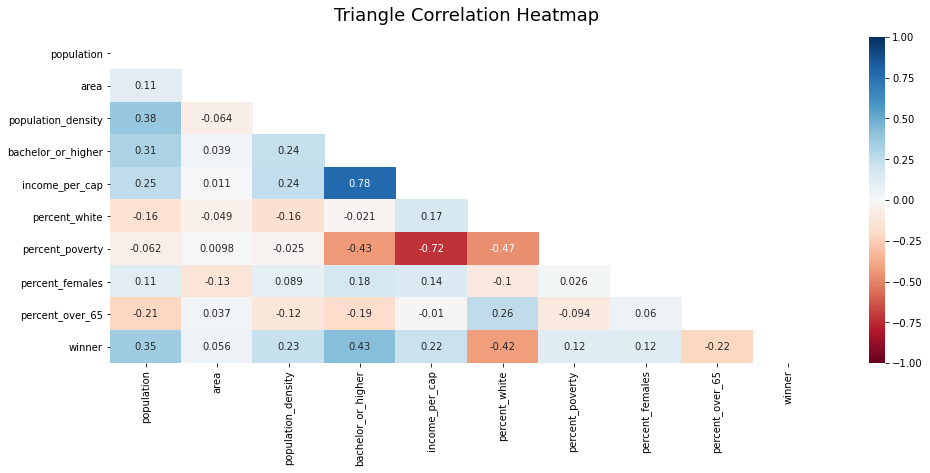

In [11]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(dataset.corr(), dtype=np.bool))
heatmap = sns.heatmap(dataset.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdBu')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

We have pretty strong correlations between a county's income per capita and its higher educated population. This makes sense because we expect a higher educated person to have a higher income than a lower educated one. There is also an expected strong negative correlation between the percentage of poverty and the income per capita.

Other than these two, no other pair surpasses |0.5| level of correlation. Some other stronger correlations include a negative correlation between the percentage of poverty and the percentage of higher educated people, as well as a negative correlation between the percentage of poverty and the percentage of white people.

Let's now graph the distributions of all the factors and see how they look visually:

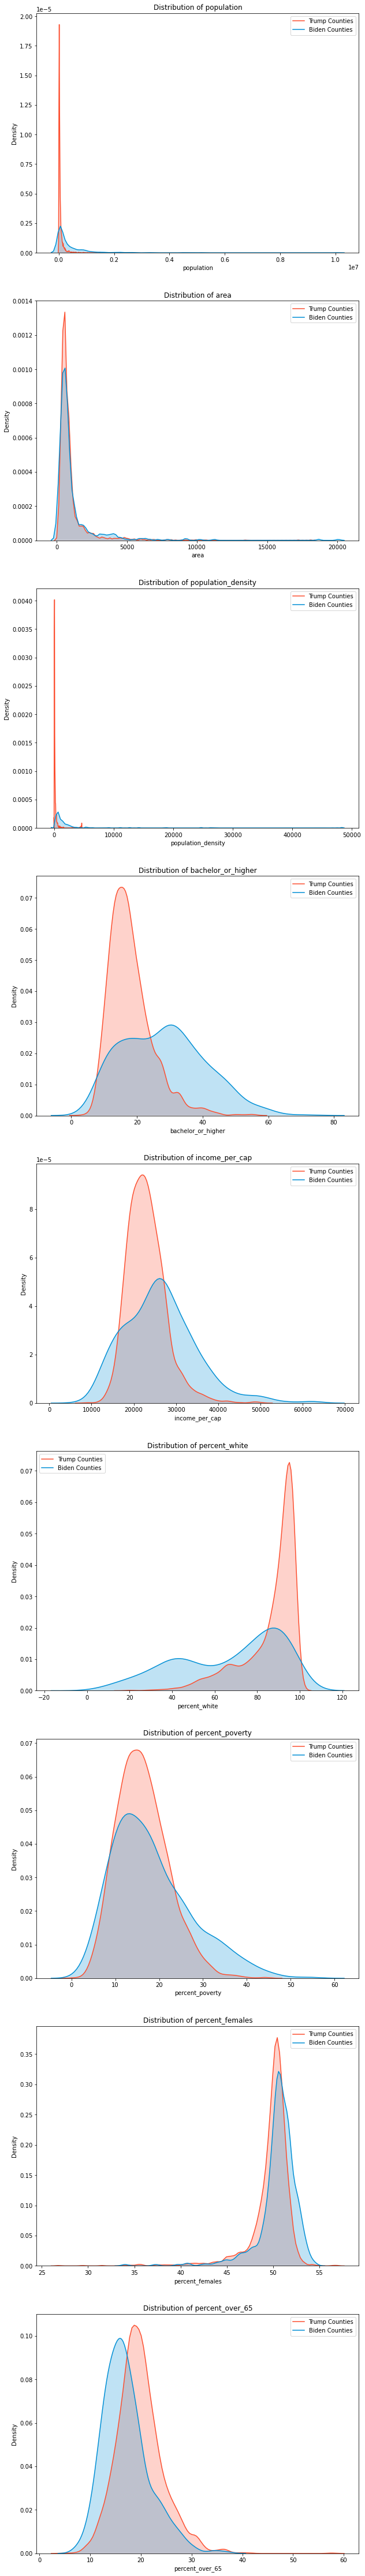

In [12]:
trump_counties = dataset.loc[dataset['winner'] == 0]
biden_counties = dataset.loc[dataset['winner'] == 1]

num_cols = len(dataset.columns[1:-1])
plt.figure(figsize=(10, num_cols*9))

for i, col in enumerate(dataset.columns[1:-1]):
    plt.subplot(num_cols, 1, i + 1)
    sns.kdeplot(trump_counties[col], label = 'Trump Counties', color = '#fc4f30', shade=True)
    sns.kdeplot(biden_counties[col], label = 'Biden Counties', color = '#008fd5', shade=True)
    plt.ylabel('Density')
    plt.xlabel('%s' % col)
    plt.title('Distribution of %s' % col)

plt.show()

In the first graph (Distribution of population), we can see that the density of very, very small counties is much, much bigger for Trump counties. In the next graph, we see the same thing for the density of counties with very small areas, although here the difference between the counties of both candidates is not so dramatic.

In the graph Distribution of bachelor_or_higher, we can see that Trump counties have a pretty thin margin of percentages, centered around the mean of 18, whereas Biden counties have a much larger standard deviation that covers values from 0 all the way to the 60s and above. We can see a similar trend for the income per capita distribution.

In the graph Distribution of percent_white, we can see a sudden and large spike of density of counties with a percentage of white people that is over 80%. We can also see that hardly any counties with a population of white people under 40% has voted for Donald Trump.

The graph Distribution of percent_poverty features similar standard deviations for the percentage of poverty of the counties of both candidates, however for Donald Trump's counties, it is slightly narrower.

Finally, the graph Distribution of percent_over_65 clearly shows how Trump's counties have a population with a noticeably higher percentage of elderly people than Biden's counties.

## II. Classification Task

I will now build a random forest model to predict the election results for the counties. I will also use the Receiver Operating Characteristic (ROC) score to measure the model's performance in addition to the accuracy score.

Let's first separate the features from the labels and split the data into train and test sets on a 80:20 basis.

In [13]:
features = dataset[dataset.columns[1:-1]]
y = dataset['winner'].values
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2)

In [14]:
len(X_test)

615

In [15]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [16]:
print('Score using original features: ', model.score(X_test, y_test))
print('ROC score using original features: ', roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

Score using original features:  0.9154471544715447
ROC score using original features:  0.9357281553398058


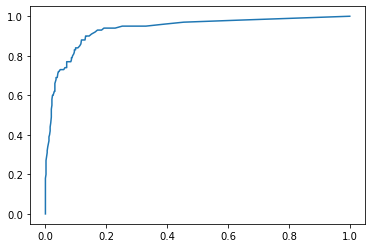

In [17]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr)
plt.show()

This is a very good result so far! Our model predicts correctly in 91.6% of cases. The ROC score is also very good with 93.6% of the area falling under the curve.

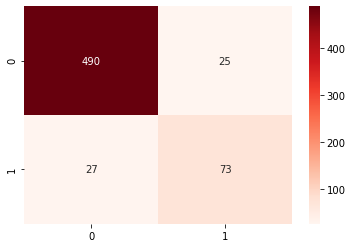

In [18]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Reds', fmt='g')
plt.show()

Our model predicts a Trump county correctly 95% of the times, but a Biden county correctly only 73% of the times. This might be due to the much lower amount of counties in which Biden has won.

Let's see whether our model is truly good, or it is just overfitting:

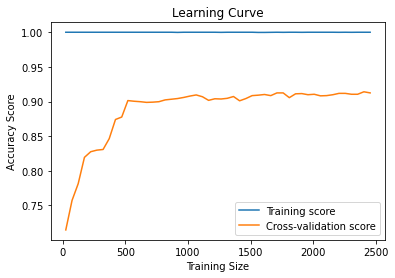

In [19]:
train_sizes, train_scores, test_scores = learning_curve(model, features, y, n_jobs=-1, train_sizes=np.linspace(0.01, 1, 50))
train_mean = np.mean(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)

plt.plot(train_sizes, train_mean, label = 'Training score')
plt.plot(train_sizes, test_mean, label = 'Cross-validation score')
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

It seems like it does not overfit and overally does a pretty good job. However, it is far from perfect. I will now try to do some feature engineering to see if I can improve the algorithm in any meaningful way.

Let's start with a polynomial transformation first:

In [20]:
poly_transformer = PolynomialFeatures(degree=3, include_bias=False)
poly_transformer.fit(features)
poly_features = poly_transformer.transform(features)
feature_names = poly_transformer.get_feature_names(input_features=features.columns)
poly_features.shape

(3071, 219)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.2)
poly_model = RandomForestClassifier()
poly_model.fit(X_train, y_train)
print('Score using polynomial features: ', poly_model.score(X_test, y_test))
print('ROC score using polynomial features: ', roc_auc_score(y_test, poly_model.predict_proba(X_test)[:, 1]))

Score using polynomial features:  0.9186991869918699
ROC score using polynomial features:  0.9344425426899654


This transformation increased the score very slightly, but nowhere near any significant level.

Let's now try to scale the features and see if that improves anything:

In [22]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.2)
scaled_model = RandomForestClassifier()
scaled_model.fit(X_train, y_train)
print('Score using scaling: ', scaled_model.score(X_test, y_test))
print('ROC score using scaling: ', roc_auc_score(y_test, scaled_model.predict_proba(X_test)[:, 1]))

Score using scaling:  0.9203252032520325
ROC score using scaling:  0.9393495145631068


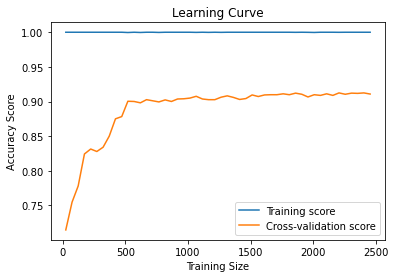

In [23]:
train_sizes, train_scores, test_scores = learning_curve(scaled_model, scaled_features, y, n_jobs=-1, train_sizes=np.linspace(0.01, 1, 50))
train_mean = np.mean(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)

plt.plot(train_sizes, train_mean, label = 'Training score')
plt.plot(train_sizes, test_mean, label = 'Cross-validation score')
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

This is a better result than both the original model and the polynomial features one, but it is also far from perfect. Oh well, this might be the limit of what model can be created using the current data. At least this model doesn't overfit either. It might be good enough.

Let's now add the county names and the labels back to the dataset in order to do some prediction.

In [24]:
county = pd.DataFrame(dataset['county'])
scaled_features = county.join(pd.DataFrame(scaled_features))
y = pd.DataFrame(y)
y.columns = ['winner']
scaled_features = scaled_features.join(y)
scaled_features

,county,0,1,2,3,4,5,6,7,8,winner
0,"Autauga County, Alabama",0.005548,0.028446,0.001944,0.258394,0.306966,0.762567,0.210923,0.817276,0.204545,0
1,"Baldwin County, Alabama",0.022220,0.078152,0.002907,0.357664,0.347075,0.875936,0.244821,0.820598,0.295455,0
2,"Barbour County, Alabama",0.002442,0.042968,0.000574,0.148905,0.165497,0.467380,0.485876,0.677741,0.276515,0
3,"Bibb County, Alabama",0.002214,0.029893,0.000741,0.129927,0.176424,0.763636,0.323917,0.664452,0.221591,0
4,"Blount County, Alabama",0.005743,0.030991,0.001854,0.129927,0.236780,0.967914,0.280603,0.794020,0.253788,0
...,...,...,...,...,...,...,...,...,...,...,...
3066,"Sweetwater County, Wyoming",0.004201,0.519114,0.000079,0.217518,0.415616,0.793583,0.195857,0.720930,0.138258,0
3067,"Teton County, Wyoming",0.002320,0.198822,0.000116,0.664234,0.651829,0.805348,0.137476,0.717608,0.200758,1
3068,"Uinta County, Wyoming",0.001998,0.102705,0.000196,0.229197,0.324179,0.878075,0.233522,0.747508,0.176136,0
3069,"Washakie County, Wyoming",0.000761,0.110590,0.000067,0.297810,0.375251,0.825668,0.210923,0.750831,0.320076,0


In [25]:
def predict_winner(county, model):
    X = scaled_features[scaled_features['county'] == county][scaled_features.columns[1:-1]]
    y = scaled_features[scaled_features['county'] == county]['winner'].values[0]
    prediction  = model.predict(X)[0]
    print(county)
    print("Predicted Winner: {0}\nActual Winner: {1}\n".format(prediction, y))

This will generate a random sample of 15 counties and will predict the winner in them based on their socio-economic factors. Remember, **0** is **Donald Trump** and **1** is **Joe Biden**.

In [26]:
random_counties = scaled_features.sample(n=15)
random_counties

,county,0,1,2,3,4,5,6,7,8,winner
1066,"Russell County, Kentucky",0.001769,0.011478,0.001458,0.127007,0.170577,0.977540,0.497175,0.800664,0.291667,0
74,"Maricopa County, Arizona",0.446785,0.459128,0.010078,0.388321,0.356028,0.831016,0.297552,0.787375,0.196970,1
2574,"Garza County, Texas",0.000612,0.043517,0.000141,0.091971,0.153547,0.898396,0.274953,0.232558,0.119318,0
151,"Union County, Arkansas",0.003836,0.051452,0.000755,0.188321,0.236560,0.627807,0.387947,0.813953,0.248106,0
1136,"Tensas Parish, Louisiana",0.000415,0.030791,0.000135,0.103650,0.171820,0.394652,0.629002,0.823920,0.371212,1
2451,"Madison County, Tennessee",0.009744,0.017517,0.005413,0.144526,0.236944,0.905882,0.288136,0.803987,0.214015,0
633,"Morgan County, Illinois",0.003336,0.027198,0.001221,0.255474,0.302690,0.903743,0.254237,0.744186,0.287879,0
2991,"Douglas County, Wisconsin",0.004281,0.063879,0.000681,0.270073,0.317162,0.927273,0.267420,0.767442,0.261364,1
2758,"Morgan County, Utah",0.000997,0.029195,0.000341,0.440876,0.338084,0.982888,0.058380,0.714286,0.126894,0
2721,"Uvalde County, Texas",0.002665,0.076505,0.000354,0.164964,0.177375,0.963636,0.482109,0.797342,0.227273,0


In [27]:
for county in random_counties['county']:
    predict_winner(county, scaled_model)

Russell County, Kentucky
Predicted Winner: 0
Actual Winner: 0

Maricopa County, Arizona
Predicted Winner: 1
Actual Winner: 1

Garza County, Texas
Predicted Winner: 0
Actual Winner: 0

Union County, Arkansas
Predicted Winner: 0
Actual Winner: 0

Tensas Parish, Louisiana
Predicted Winner: 1
Actual Winner: 1

Madison County, Tennessee
Predicted Winner: 0
Actual Winner: 0

Morgan County, Illinois
Predicted Winner: 0
Actual Winner: 0

Douglas County, Wisconsin
Predicted Winner: 1
Actual Winner: 1

Morgan County, Utah
Predicted Winner: 0
Actual Winner: 0

Uvalde County, Texas
Predicted Winner: 0
Actual Winner: 0

Pickens County, South Carolina
Predicted Winner: 0
Actual Winner: 0

Val Verde County, Texas
Predicted Winner: 0
Actual Winner: 0

New London County, Connecticut
Predicted Winner: 0
Actual Winner: 1

Polk County, Florida
Predicted Winner: 0
Actual Winner: 0

Oconto County, Wisconsin
Predicted Winner: 0
Actual Winner: 0



The model predicted correctly the winner in 14 out of the 15 randomly selected states, or a 93% success, which is precisely the accuracy value of this model. It is also consistent with the fact that the wrongly predicted county was a Biden one.

## III. Conclusion

In conclusion, the random forest model does a pretty good job of predicting a presidential candidate winner by county solely based on a small number of socio-economic features. There is, however, a non-negligeable amout of counties that prove difficult to predict based on this data alone. This project can be improved by introducing more features or including the results of past elections.

## References


* Index Mundi Country Facts. Retrieved November 19, 2020, from https://www.indexmundi.com/
* Fontes, R. (2020, November 18). US Election 2020. Retrieved November 19, 2020, from https://www.kaggle.com/unanimad/us-election-2020